In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import numpy as np
import torch
import scanpy as sc
import muon as mu
import anndata
import mudata
import pandas as pd

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
mdata = mu.read("data/mdata_preprocessed_final_5k_obs.h5mu")
mdata

MuData object with n_obs × n_vars = 5000 × 41910
  obs:	'imagerow', 'imagecol', 'ann', 'sample', 'patient'
  2 modalities
    rna:	5000 x 29400
      obs:	'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'size_factors', 'sample', 'type', 'patient', 'clusters', 'tissue', 'imagerow', 'imagecol', 'ann'
      obsm:	'X_pca', 'X_umap', 'spatial'
      layers:	'counts', 'scran_normalization', 'spotclean'
    msi:	5000 x 12510
      obs:	'ST_barcode', 'sample', 'tissue', 'imagerow', 'imagecol', 'ann', 'patient'
      var:	'mz_values'
      obsm:	'spatial'

In [5]:
from src.utils import setup_mudata
setup_mudata(mdata)

n_cells = mdata["rna"].shape[0]
batch_id = torch.ByteTensor(mdata["rna"].obs.loc[:, "batch_id"].values)
_, N_b = torch.unique(batch_id, sorted=True, return_counts=True)
N_b.view(-1, 1) / n_cells

tensor([[0.0734],
        [0.0716],
        [0.0672],
        [0.0770],
        [0.0604],
        [0.0612],
        [0.0578],
        [0.0514],
        [0.0588],
        [0.0716],
        [0.0716],
        [0.0564],
        [0.0460],
        [0.0478],
        [0.0708],
        [0.0570]])

In [14]:
N_b.size(dim=0)

16

In [129]:
batch_codes = mdata["rna"].obs["sample"].astype("category")

In [88]:
ids = torch.as_tensor(batch_codes.cat.codes.values, dtype=torch.long).view(-1, 1)

In [82]:
ids

tensor([[ 8],
        [ 8],
        [ 5],
        ...,
        [ 8],
        [ 5],
        [10]], dtype=torch.int8)

In [7]:
Phi = torch.zeros(n_cells, N_b.size(dim=0))
Phi

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [11]:
Phi1 = torch.scatter(Phi, 1, batch_id_long, 1.0)
Phi1[10]

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
from src.model import MVAE, MVAEParams

mvae_params = MVAEParams(beta=0.01, n_layers=2, z_dim=100, n_hidden=300)

In [6]:
torch.set_num_threads(16)
model = MVAE(mdata, mvae_params, use_cuda=True)
model

N batches for mod1:  16
N batches for mod2:  16
(5000, 29400)
(5000, 12510)


MVAE(
  (rna): ModalityLayers(
    (shared_sampling): SamplingLayers(
      (mean): Sequential(
        (0): Linear(in_features=300, out_features=100, bias=True)
        (1): Dropout(p=0.3, inplace=False)
      )
      (logvar): Sequential(
        (0): Linear(in_features=300, out_features=100, bias=True)
        (1): Dropout(p=0.3, inplace=False)
      )
    )
    (batch_sampling): SamplingLayers(
      (mean): Sequential(
        (0): Linear(in_features=300, out_features=1600, bias=True)
        (1): Dropout(p=0.3, inplace=False)
      )
      (logvar): Sequential(
        (0): Linear(in_features=300, out_features=1600, bias=True)
        (1): Dropout(p=0.3, inplace=False)
      )
    )
    (private_sampling): SamplingLayers(
      (mean): Sequential(
        (0): Linear(in_features=300, out_features=100, bias=True)
        (1): Dropout(p=0.3, inplace=False)
      )
      (logvar): Sequential(
        (0): Linear(in_features=300, out_features=100, bias=True)
        (1): Dropout(p=0.

In [7]:
from src.train import train_mvae, TrainParams
train_params = TrainParams(train_size=0.8, n_epochs=100, learning_rate=1e-4, batch_size=128)

In [8]:
corr, output = train_mvae(model, mdata, train_params)

Train data size: 4000
Test data size: 1000


  0%|                                                    | 0/32 [00:00<?, ?it/s]/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/threadpoolctl.py:762: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).


  0%|                                                    | 0/32 [00:02<?, ?it/s]

	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


In [25]:
import torch.nn.functional as F
print(F.one_hot(torch.arange(0, 5) % 3))

batch_id = torch.arange(0,5) % 3
ids = batch_id.view(-1, 1)
Phi = torch.zeros(5, 3, dtype=torch.float)
Phi.scatter_(dim=1, index=ids, value=1.0)
print(Phi)

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0]])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_scatter__value)

In [13]:
poe

array([[-0.46017826, -0.3220197 , -2.0265217 , ...,  0.54139006,
        -0.11672272, -0.51510614],
       [ 0.4786482 ,  0.8647929 ,  0.7809398 , ..., -0.1188563 ,
         0.15776072,  0.678091  ],
       [ 0.4678871 ,  0.33735198,  0.104856  , ..., -0.3356654 ,
         1.1674511 , -0.24234909],
       ...,
       [-0.41131175, -0.81204814,  0.07941402, ...,  0.8762194 ,
         0.52539575, -0.77060735],
       [-0.5926063 , -0.5671338 ,  0.3368605 , ..., -0.3473547 ,
         0.38557297,  0.41594446],
       [ 0.2661963 ,  0.69151855,  0.531208  , ..., -0.28990647,
         0.31905442, -1.4018652 ]], dtype=float32)

In [19]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(corr)

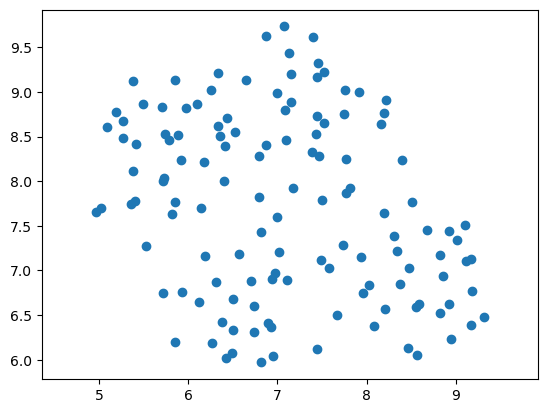

In [20]:
import matplotlib.pyplot as plt
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')